In [2]:
%matplotlib inline
import io

import cv2
import numpy as np
import PIL.Image

from matplotlib import pyplot as plt
from IPython.display import Image, display

from transform import weights
from transform.purifier import ImagesPurifier, extract_changing_region
from transform.stat import create_image_histogram

In [3]:
titles = [f"d00{i+1}.jpg" for i in range(5)]
# images = [cv2.imread(f"data/{title}") for title in titles]

images = [cv2.imread(f"data_2/{title}") for title in titles]
result = cv2.imread(f"data/result.png")

def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    f = io.BytesIO()
    PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255)).save(f, "png")
    display(Image(data=f.getvalue()))

def show_image_color_density_plot(image: np.ndarray) -> None:
    histograms = create_image_histogram(image).T
    densities = histograms / np.repeat(np.sum(histograms, axis=1), 256).reshape(3, 256)

    plt.plot(densities[0], color="blue")
    plt.plot(densities[1], color="green")
    plt.plot(densities[2], color="red")
    plt.show()


c:\Users\sbart\OneDrive - put.poznan.pl\Semestr V\Computer Vision\Project 1\transform\weights.py:80: RuntimeWarning: invalid value encountered in true_divide
  weights_norm = weights_stacked / np.atleast_3d(np.sum(weights_stacked, axis=2))


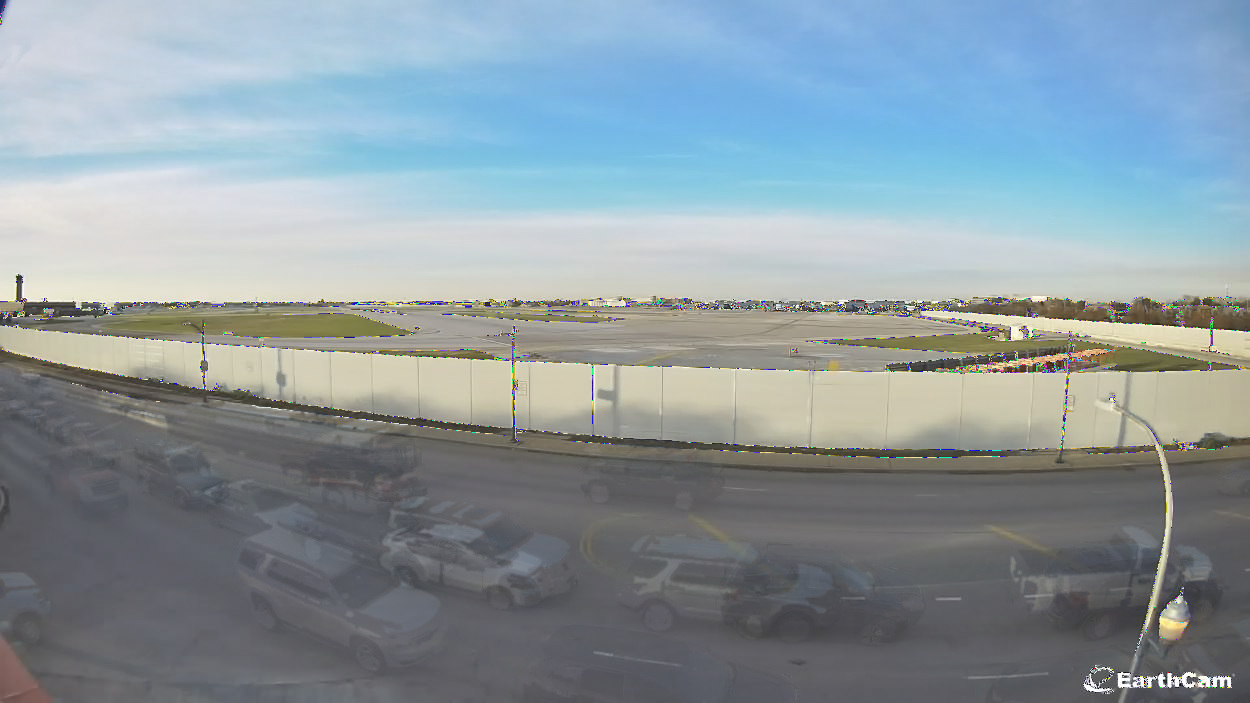

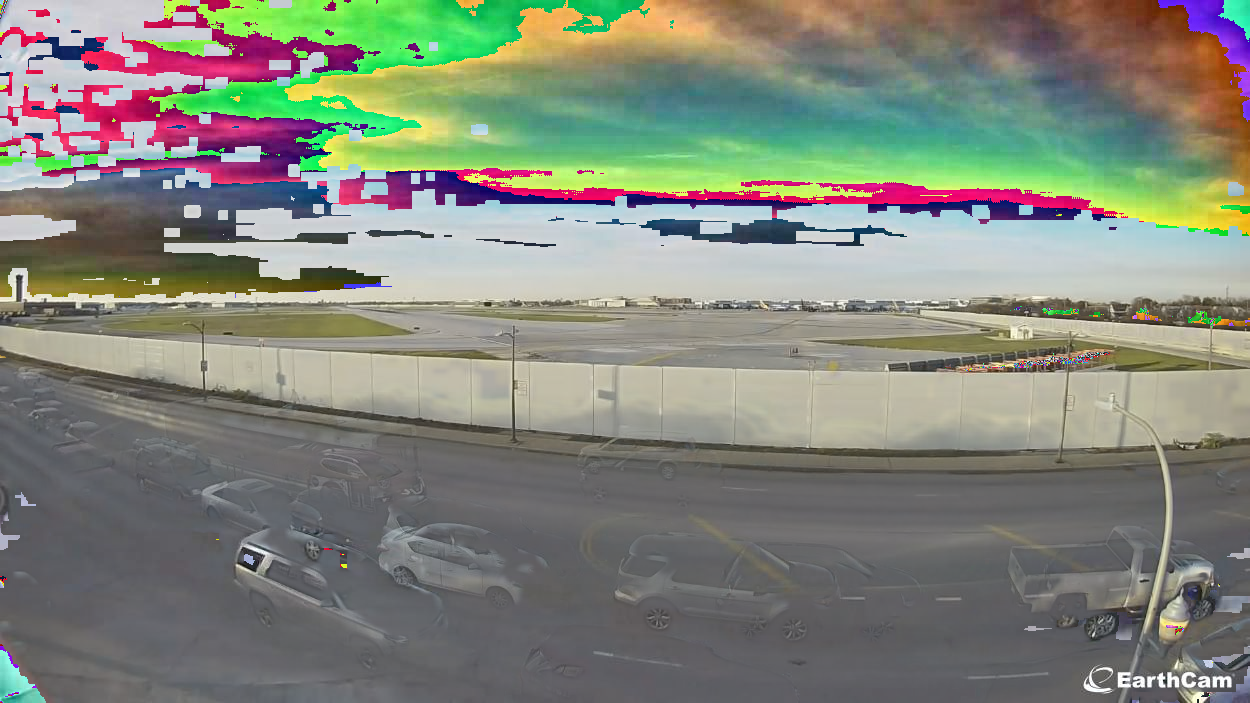

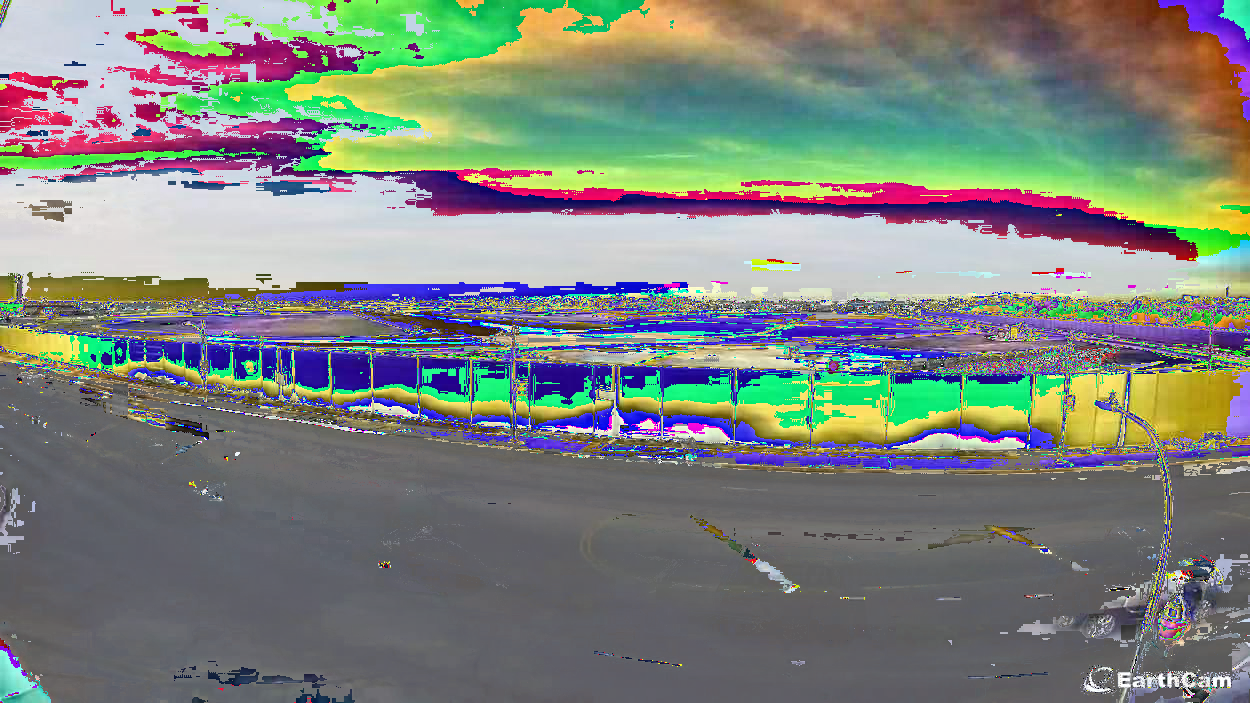

In [5]:
cr = extract_changing_region(images, 5)
purifier = ImagesPurifier(images, use_max_merge=False, changing_region=cr)
showarray(purifier.purify_with_edge_weight())
showarray(purifier.purify_with_mean_pixel_distance_and_channel_intensity())
showarray(purifier.purify_with_pixel_probability())

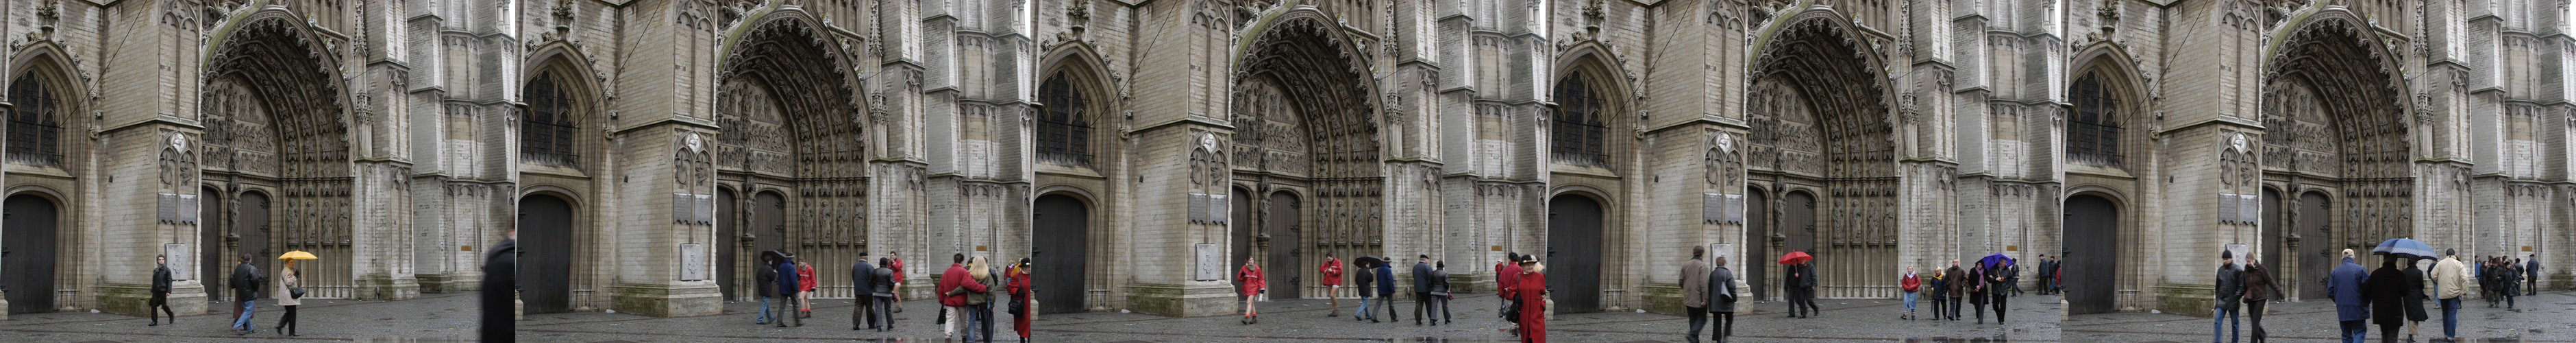

In [4]:
showarray(np.concatenate(images, axis=1))

In [8]:
def merge_images_by_weighted_average(
    images: list[np.ndarray], weights: list[np.ndarray]
) -> np.ndarray:
    weights_stacked = np.dstack(weights)
    # Normalize weights so that the final sum for each pixel is between 0 and 255
    weights_norm = weights_stacked / np.atleast_3d(np.sum(weights_stacked, axis=2))
    weights_destacked = np.array([np.nan_to_num(weights_norm, nan=1)]).swapaxes(0, 3)
    result = np.sum(np.array(images) * weights_destacked, axis=0).astype(np.uint8)

    return result

In [11]:
prob_weights = [weights.get_histogram_weight(image) for image in images]
for weight, image in zip(prob_weights, images):
    weight[:] = np.clip(
        weight - weights.get_standard_deviation_weight(image), 0, 1
    )

# showarray(merge_images_by_weighted_average(images, prob_weights))

In [17]:
weights_stacked = np.dstack(prob_weights)
# Normalize weights so that the final sum for each pixel is between 0 and 255
weights_norm = weights_stacked / np.atleast_3d(np.sum(weights_stacked, axis=2))
weights_destacked = np.array([np.nan_to_num(weights_norm, nan=1)]).swapaxes(0, 3)
result = np.sum(np.array(images) * weights_destacked, axis=0).astype(np.uint8)
weights_destacked

C:\Users\sbart\AppData\Local\Temp\ipykernel_18624\1559670263.py:3: RuntimeWarning: invalid value encountered in true_divide
  weights_norm = weights_stacked / np.atleast_3d(np.sum(weights_stacked, axis=2))


array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [0.]]],


       [[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
 

In [55]:
weights_array = np.array(prob_weights)
weights_expanded = np.expand_dims(weights_array, axis=3)
weights_broadcasted = np.broadcast_to(weights_expanded, (*weights_array.shape, 3))
summed_weights = np.sum(weights_broadcasted, axis=0)
result = (np.sum(np.array(images) * weights_broadcasted, axis=0) / summed_weights).astype(np.uint8)
final = np.zeros(result.shape)
final[summed_weights == 0] = images[0][summed_weights == 0]
final[summed_weights > 0] = result[summed_weights > 0]

C:\Users\sbart\AppData\Local\Temp\ipykernel_18624\2733762779.py:5: RuntimeWarning: invalid value encountered in true_divide
  result = (np.sum(np.array(images) * weights_broadcasted, axis=0) / summed_weights).astype(np.uint8)


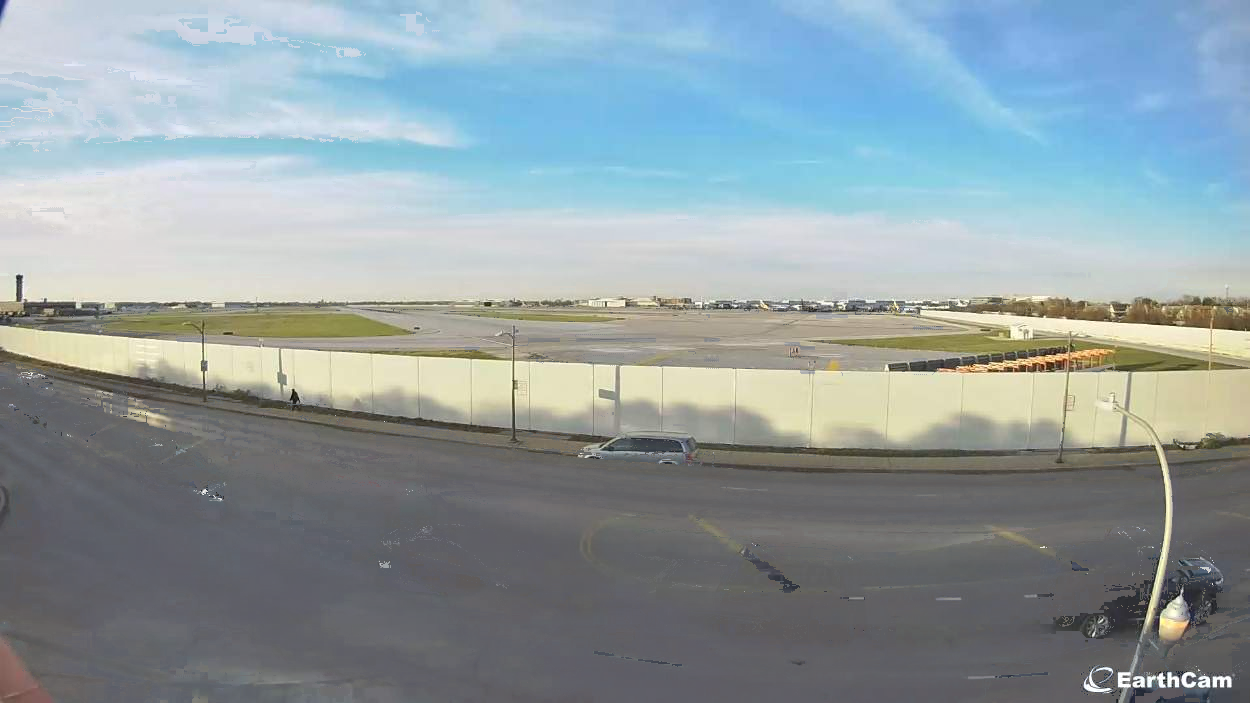

In [57]:
showarray(final.astype(np.uint8))